## Workflow Part 1: FLUTE (The FiLter for Understanding True Events)

###  1.1. Reading the input file: a BioRECIPE interaction format spreadsheet

- FLUTE seeks to identify high-confidence signaling events from biomedical NLP output by comparing with existing biological databases.
- For this workflow demonstration, we will be using a subset of interactions (unfiltered signaling events) queried from [INDRA](http://www.indra.bio) machine reading engine. The interaction list has been formatted to BioRECIPE interaction style, using this provided [translator](https://github.com/pitt-miskov-zivanov-lab/BioRECIPE/blob/main/examples/use_translators.ipynb).

In [ ]:
import sys,os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, 'FLUTE', 'src')))
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import mysql.connector
import run_FLUTE

#Add username and password for local FLUTE DB
db_user="root"
db_password="12345678"
db_host="localhost"
db_name="flute"

#db=mysql.connector.connect(host=db_host, user=db_user, password=db_password,database=db_name)
#cursor=db.cursor()
#cursor.execute("SHOW TABLES")
#for table_name in cursor:
    #print(table_name[0])

#pd.read_sql('SELECT * FROM unistringmapping', con=db)

## Workflow Part 2: VIOLIN (Validating Interactions Of Likely Importance to the Network)

In [1]:
import sys
import os
import warnings
import tempfile
import pandas as pd
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(),os.pardir, os.pardir, 'VIOLIN', 'src', 'violin')))

from in_out import input_biorecipes,input_reading,output, biorecipe_to_violin
from scoring import score_reading
from network import node_edge_list
from formatting import convert_reading
from visualize_violin import visualize
from utils import *

In [2]:
model_file = 'workflow/Tcell_model_biorecipe.xlsx'
reading_file = 'workflow/workflow_after_flute.xlsx'
out_file = 'workflow/Tcell'

In [3]:
###Parameters###
 
#Scoring values defined
kind_dict = {"strong corroboration" : 2, 
                "weak corroboration1" : 1,
                "weak corroboration2" : 1,
                "weak corroboration3" : 1,
                "hanging extension" : 40, 
                "full extension" : 40, 
                "internal extension" : 40, 
                "specification" : 30, 
                "dir contradiction" : 10,
                "sign contradiction" : 10,
                "att contradiction" : 10,
                "flagged1" : 20,
                "flagged2" : 20,
                "flagged3" : 20}
match_dict = {"source present" : 1, 
                "target present" : 100, 
                "both present" : 10, 
                "neither present" : 0.1}
#These column names are the attributes used to determine 
#duplicate interactions in evidence_score()
evidence_score_cols = ['Element Name','Element Type','Element ID','Location',
                       'Location ID','Cell Line','Cell Type','Organism',
                       'Positive Reg Name','Positive Reg Type','Positive Reg ID',
                       'Positive Reg Location','Positive Reg Location ID',
                       'Negative Reg Name','Negative Reg Type','Negative Reg ID',
                       'Negative Reg Location','Negative Reg Location ID','Connection Type']
#Attributes Compared
attributes = ['Location ID']  

In [4]:
###_Format wrapping_###

model_tf = tempfile.NamedTemporaryFile(suffix='.xlsx')
reading_tf = tempfile.NamedTemporaryFile(suffix='.xlsx')
norm_model(model_file, model_tf)
reading_df = biorecipe_to_violin(reading_file)
reading_df.to_excel(reading_tf, index=False)

In [5]:
###_File input and formatting_###
###This assumes the input files match the default input REACH and BioRECIPES formats###

model_df = input_biorecipes(model_tf.name)

#reading_df, reading_cols = input_reading(VIOLIN_reading=reading_file, evidence_score_cols=evidence_score_cols, atts = attributes)
reading_df, reading_cols = input_reading(reading=reading_tf.name, evidence_score_cols=evidence_score_cols, atts = attributes)

graph = node_edge_list(model_df)

In [6]:
###_Scoring_###

scored = score_reading(reading_df,model_df,graph,reading_cols,kind_values = kind_dict,match_values = match_dict,attributes = attributes)

962


In [7]:
###_Output_###

output(scored,out_file,kind_values=kind_dict)

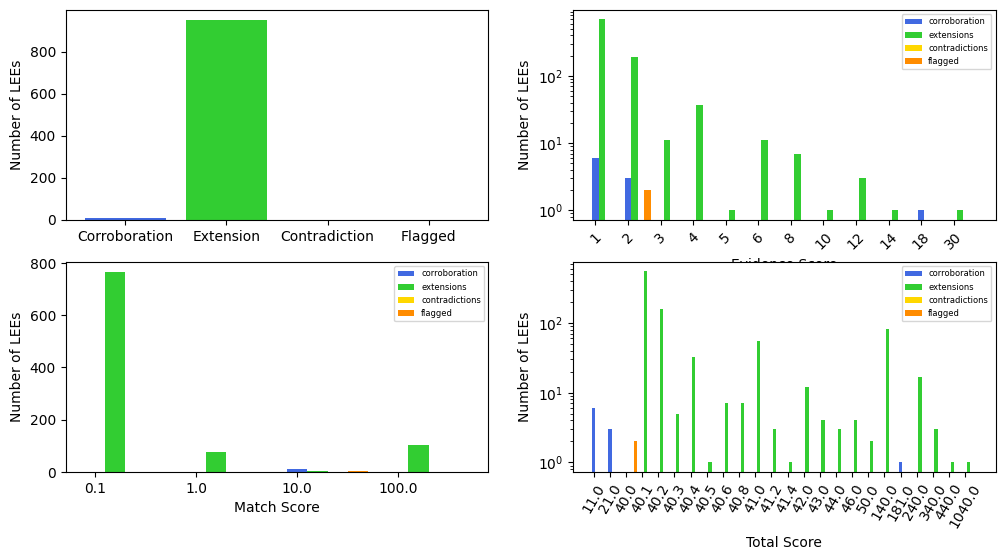

In [8]:
###_Visualization_###
visualize(match_dict, kind_dict, out_file+'_outputDF.csv', filter_opt='100%')

## Workflow Part 3: CLARINET (CLARIfying NETworks)

In [11]:
import os
import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
# Add src folder to environmental path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(),os.pardir, os.pardir, 'CLARINET', 'src')))

### 3.1 Loading model & extracted event, creating ECLG

In [13]:
# To keep root folder intact, load inputs from tutorial directory 'examples/input/'
in_dir = 'workflow'
isExist = os.path.exists(in_dir)
if not isExist:
    os.makedirs(in_dir)

In [14]:
# support your input baseline model here
model_file = 'Tcell_model_biorecipe.xlsx'
baseline = os.path.join(in_dir, model_file)

In [15]:
# Load baseline model file into two dictionaries
# we highlight the key information of the baseline model
from runClarinet import get_model
model_dict, regulators = get_model(baseline)
df_model = pd.read_excel(baseline, index_col=0)
df_model[['Element Name','Element IDs','Positive Regulation Rule','Negative Regulation Rule','Levels','State List 0']]

,Element Name,Element IDs,Positive Regulation Rule,Negative Regulation Rule,Levels,State List 0
#,,,,,,
1,AKT,P31749,"(PDK1,MTORC2)",AKT_OFF,2,0
2,AKT_OFF,P31749,NaN,NaN,2,0
3,AP1,"P05412,P01100","(FOS_DD,JUN)",NaN,2,0
4,CA,NaN,TCR,NaN,2,0
5,CD122,P14784,NaN,NaN,2,1
...,...,...,...,...,...,...
58,TCR_HIGH,"P01850,P01848",NaN,NaN,2,0
59,TCR_LOW,"P01850,P01848",NaN,NaN,2,0
60,TGFBETA,P01137,NaN,NaN,2,0


In [16]:
# 'model_dict' is a dictionary that holds critical information of each baseline model element
# 'regulators' is another dictionary that contains baseline model elements and corresponding regulator elements
# model_dict
regulators

{'AKT': {'AKT_OFF', 'MTORC2', 'PDK1'},
 'AKT_OFF': set(),
 'AP1': {'FOS_DD', 'JUN'},
 'CA': {'TCR'},
 'CD122': set(),
 'CD132': set(),
 'CD25': {'AP1', 'FOXP3', 'NFAT', 'NFKAPPAB', 'STAT5'},
 'CD28': set(),
 'ERK': {'MEK2'},
 'FOS': {'ERK'},
 'FOS_D': {'FOS'},
 'FOS_DD': {'FOS_D'},
 'FOS_DDD': set(),
 'FOXP3': {'MTOR_DD', 'NFAT', 'SMAD3', 'STAT5'},
 'IL2': {'AP1', 'FOXP3', 'IL2', 'NFAT', 'NFKAPPAB'},
 'IL2_EX': {'IL2', 'IL2_EX'},
 'IL2R': {'CD122', 'CD132', 'CD25'},
 'JAK3': {'IL2R', 'IL2_EX'},
 'JNK': {'MKK7'},
 'JUN': {'JNK'},
 'MEK2': {'RAF'},
 'MKK7': {'TAK1'},
 'MTOR': {'MTORC1_D', 'MTORC2_D'},
 'MTOR_D': {'MTOR'},
 'MTOR_DD': {'MTOR_D'},
 'MTOR_DDD': set(),
 'MTOR_DDDD': set(),
 'MTORC1': {'MTORC1_OFF', 'RHEB'},
 'MTORC1_D': {'MTORC1'},
 'MTORC1_OFF': set(),
 'MTORC2': {'PI3K_HIGH', 'PI3K_LOW', 'S6K1'},
 'MTORC2_D': {'MTORC2'},
 'MTORC2_DD': set(),
 'NFAT': {'CA', 'NFAT_OFF'},
 'NFAT_OFF': set(),
 'NFKAPPAB': {'AKT', 'PKCTHETA'},
 'PDK1': {'PIP3'},
 'PI3K': {'PI3K_HIGH', 'PI3K_LO

In [35]:
# support your another input (extracted event information) here, it is from machine reading
reading_file = 'Tcell_extensions_converted.csv'
reading = os.path.join(in_dir, reading_file)

In [36]:
# we highlight the key information of each event
df_ro = pd.read_csv(reading)
df_ro[['Regulator Name', 'Regulator ID', 'Regulated Name','Regulated ID', 'Sign', 'Paper IDs']]

,Regulator Name,Regulator ID,Regulated Name,Regulated ID,Sign,Paper IDs
0,cd4,p01730,il-2,p60568,positive,"pmc7851051,pmc6174845,pmc7279007,pmc9315201,pm..."
1,cd19,p15391,cd28,p10747,positive,"pmc4482147,pmc7269815,pmc10010331,pmc9862812"
2,cd19,p15391,cr,p08174,positive,"pmc8939233,pmc7926700,pmc9862812"
3,pd-l1,q9nzq7,il-2,p60568,positive,"pmc7607631,pmc7607631,pmc9961031"
4,pd-l1,q9nzq7,cd28,p10747,negative,"pmc9141239,pmc10288912,pmc6558778"
...,...,...,...,...,...,...
945,vegfa,p15692,dll4,q9nr61,positive,pmc6984804
946,tet2,q6n021,dna demethylation,go:0080111,positive,pmc8593824
947,cgas,q8n884,dna repair,go:0006281,negative,pmc9062427
948,il-15,p40933,dnam-1,q15762,positive,pmc6343266


In [66]:
# create Event CoLlaboration Graph
from runClarinet import create_eclg
G = create_eclg(reading, model_dict)

INFO:root:Number of unique paper IDs: 491
INFO:root:Average interactions per paper: 1.934826883910387


In [67]:
# show the nodes in Event CoLlaboration Graph
# node name encodes the interaction it represents, in the form of:
# regulator -> regulated element -> + or -
G.nodes()

NodeView(('ctla4_ext->TCR->-', '->->-', 'il13_ext->il13r_ext->+', 'il13_ext->il13r_ext->-', 'cd19_ext->CD28->+', '->cd80_ext->+', 'CA->il6_ext->+', 'CA->->-', 'killer_ext->nkg2d_ext->-', 'killer_ext->nkg2d_ext->+', '->cd4_ext->+', '->->+', '->CA->+', 'CA->->+', '->cd86_ext->-', '->cd80_ext->-', 'cd4_ext->il15_ext->-', 'cd4_ext->il7_ext->-', 'shp2_ext->CD28->-', 'mice_ext->->+', 'cd27_ext->cd70_ext->-', 'csk_ext->lck_ext->+', 'csk_ext->fyn_ext->+', 'lck_ext->zap70_ext->+', 'icos_ext->cxcr5_ext->+', '->mice_ext->+', 'bcma_ext->baff_ext->-', 'cd19_ext->bcma_ext->-', 'cd138_ext->bcma_ext->-', 'CD28->->+', '->cd19_ext->-', 'cd19_ext->->+', 'her2_ext->->-', '->her2_ext->-', '->her2_ext->+', '->CD28->+', '->apoptosis_ext->+', 'apoptosis_ext->->-', 'CA->ccr7_ext->+', 'CA->cd40l_ext->+', 'sting_ext->tbk1_ext->+', 'tbk1_ext->sting_ext->+', 'sting_ext->irf3_ext->+', 'cd4_ext->->+', 'cd4_ext->CD28->+', 'cd4_ext->lck_ext->-', '->nck_ext->+', 'itk_ext->plcg1_ext->+', '->adhesion_ext->+', 'CD28->cd4_

In [68]:
# show some characteristics of the ECLG gragh
print('Number of nodes in the ECLG graph:', len(G.nodes()))
print('Number of edges in the ECLG graph:', len(G.edges()))
his_before = nx.degree_histogram(G)
print('Node degress distribution histogram: ',his_before)

Number of nodes in the ECLG graph: 560
Number of edges in the ECLG graph: 1192
Node degress distribution histogram:  [1, 139, 98, 64, 63, 47, 41, 16, 28, 23, 4, 23, 6, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### 3.2 Processing and weighting ECLG 

In [69]:
from runClarinet import node_weighting, edge_weighting

In [70]:
# To keep root folder intact, generate output in tutorial directory 'examples/output'
out_dir = 'output'

isExist = os.path.exists(out_dir)
if not isExist:
    os.makedirs(out_dir)

In [71]:
# set a parameter FC_TH
FC_TH = 6

In [72]:
# assign weights to nodes using frequency class
# in the meantime, remove the less frequent nodes
G = node_weighting(G, FC_TH, out_dir)

In [73]:
# show some characteristics of the ECLG gragh after removing less frequent nodes
print('Number of nodes in the ECLG graph:', len(G.nodes()))
print('Number of edges in the ECLG graph:', len(G.edges()))
his_after = nx.degree_histogram(G)
print('Node degress distribution histogram: ',his_after)

Number of nodes in the ECLG graph: 421
Number of edges in the ECLG graph: 1107
Node degress distribution histogram:  [1, 0, 100, 63, 62, 50, 39, 16, 30, 23, 3, 23, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


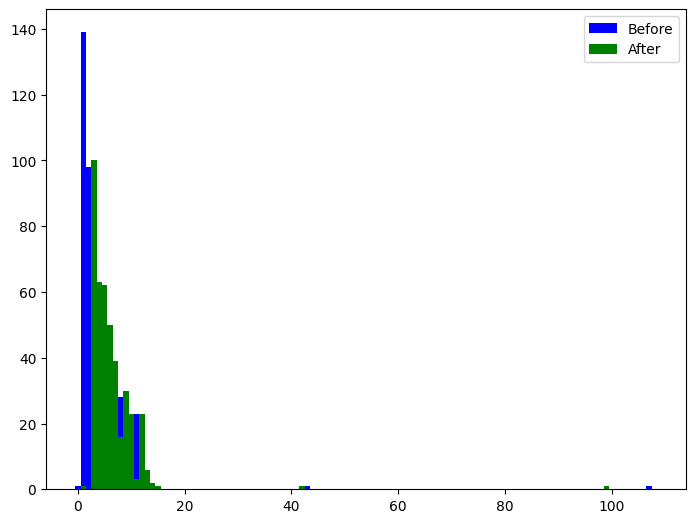

In [74]:
# draw a histogram comparison between before and after removing less frequent nodes
matched_his = max(len(his_before), len(his_after))
X = np.arange(matched_his)
while len(his_before)<matched_his:
    his_before.append(0)
while len(his_after)<matched_his:
    his_after.append(0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X  , his_before, color = 'b', width = 1)
ax.bar(X +1, his_after, color = 'g', width = 1)
ax.legend(labels=['Before', 'After'])
plt.show()

In [75]:
# assign weights to edges using frequency class
# other ways to assign weights to edges are also available, e.g., set weightMethod = 'IF'
weightMethod = 'FC'
G = edge_weighting(G, out_dir, weightMethod)

### 3.3 Clustering ECLG

INFO:root:Community centered at "->->-->1"(community label is 0) has 46 interactions:
['ctla4_ext->TCR->-->5', '->->-->1', '->cd86_ext->-->5', '->cd80_ext->-->5', 'cd27_ext->cd70_ext->-->5', 'cd19_ext->->+->4', 'her2_ext->->-->4', '->her2_ext->-->4', '->her2_ext->+->4', 'ccr4_ext->cd30_ext->+->6', 'CD28->TCR->+->5', 'NFKAPPAB->csn5_ext->+->5', 'irf3_ext->apoptosis_ext->+->5', 'ccl1_ext->ccr8_ext->+->6', 'cd40_ext->fasl_ext->+->6', '->cd4_ext->-->4', '->proliferation_ext->+->5', '->til_ext->+->5', 'msln_ext->->+->6', '->CD25->+->4', '->trail_ext->+->3', 'nkg2d_ext->nkp44_ext->+->4', '->nkp44_ext->+->4', '->nkp30_ext->+->4', '->nkg2d_ext->+->3', '->cd69_ext->+->3', 'cd70_ext->proliferation_ext->+->5', 'c5ar1_ext->->-->6', '->TCR->-->6', 'TCR->crt_ext->+->6', '->th1_ext->+->3', 'CD28->cd107a_ext->+->6', '->inflammation_ext->+->4', '->cd107a_ext->-->4', '->fasl_ext->+->4', '->hpl_ext->+->5', 'brd4_ext->batf_ext->+->5', 'epcam_ext->cxcr4_ext->-->5', 'tigit_ext->->-->4', '->tnf_ext->-->4', '

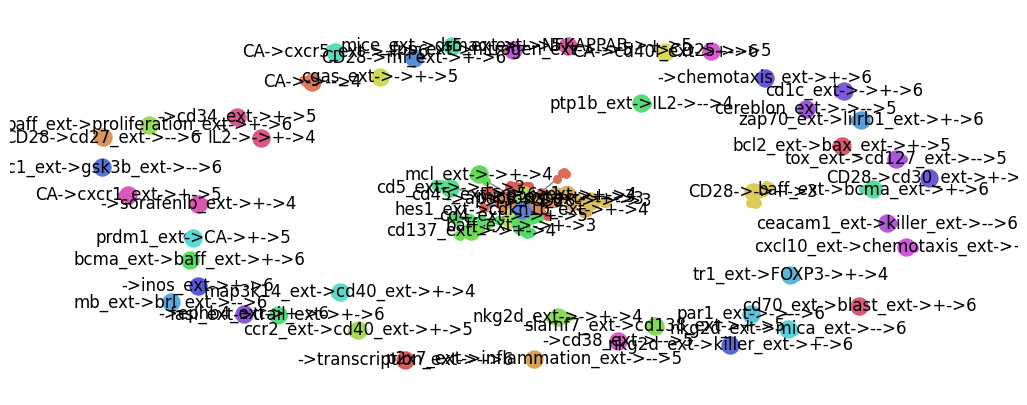

In [76]:
# cluster the ECLG using the community detection algorithm
# and save each cluster in a separate file

from runClarinet import clustering, merge_clusters, get_cluster_info
clustering(G, out_dir)

In [77]:
# check out the grouped extension
pickle.load(open(os.path.join(out_dir, "grouped_ext"),'rb'))

[[1,
  ['ctla4_ext->TCR->-->5', '->->-->1', 3],
  ['ctla4_ext->TCR->-->5', 'CD28->TCR->+->5', 4],
  ['ctla4_ext->TCR->-->5', 'NFKAPPAB->csn5_ext->+->5', 4],
  ['ctla4_ext->TCR->-->5', 'irf3_ext->apoptosis_ext->+->5', 4],
  ['->->-->1', '->cd86_ext->-->5', 4],
  ['->->-->1', '->cd80_ext->-->5', 4],
  ['->->-->1', 'cd27_ext->cd70_ext->-->5', 3],
  ['->->-->1', 'cd19_ext->->+->4', 4],
  ['->->-->1', 'her2_ext->->-->4', 4],
  ['->->-->1', '->her2_ext->-->4', 4],
  ['->->-->1', '->her2_ext->+->4', 4],
  ['->->-->1', 'ccr4_ext->cd30_ext->+->6', 2],
  ['->->-->1', 'CD28->TCR->+->5', 3],
  ['->->-->1', 'NFKAPPAB->csn5_ext->+->5', 3],
  ['->->-->1', 'irf3_ext->apoptosis_ext->+->5', 3],
  ['->->-->1', 'ccl1_ext->ccr8_ext->+->6', 4],
  ['->->-->1', 'cd40_ext->fasl_ext->+->6', 4],
  ['->->-->1', '->cd4_ext->-->4', 3],
  ['->->-->1', '->nkg2d_ext->+->3', 4],
  ['->->-->1', '->cd69_ext->+->3', 4],
  ['->->-->1', 'cd70_ext->proliferation_ext->+->5', 3],
  ['->->-->1', '->th1_ext->+->3', 4],
  ['->->-

In [78]:
# return basic information for each generated cluster
get_cluster_info(os.path.join(out_dir, 'GeneratedClusters'), os.path.join(out_dir, 'LSS'), out_dir)

,Cluster_index,Nodes,Edges,Density,AvgPathLength,Coeff,LSS,NodesX,EdgesX,DensityX,AvgPathLength,CoeffX,FreqClass,node_perc
12,12.0,3.0,3.0,1.000000,0.666667,1.000000,4.000000,4.0,3.0,0.500000,1.125000,0.000000,0.0,50.000000
15,15.0,3.0,3.0,1.000000,0.666667,1.000000,4.000000,6.0,3.0,0.200000,0.500000,0.000000,0.0,16.666667
23,23.0,3.0,3.0,1.000000,0.666667,1.000000,3.666667,5.0,3.0,0.300000,0.769231,0.000000,0.0,0.000000
24,24.0,12.0,66.0,1.000000,0.916667,1.000000,3.787879,7.0,10.0,0.476190,1.306122,0.666667,0.0,28.571429
48,48.0,3.0,3.0,1.000000,0.666667,1.000000,4.000000,4.0,3.0,0.500000,1.250000,0.000000,0.0,0.000000
41,41.0,3.0,3.0,1.000000,0.666667,1.000000,4.000000,5.0,3.0,0.300000,0.769231,0.000000,0.0,20.000000
46,46.0,3.0,3.0,1.000000,0.666667,1.000000,4.000000,6.0,3.0,0.200000,0.500000,0.000000,0.0,16.666667
25,25.0,3.0,3.0,1.000000,0.666667,1.000000,3.666667,5.0,3.0,0.300000,0.769231,0.000000,0.0,0.000000
22,22.0,10.0,45.0,1.000000,0.900000,1.000000,3.377778,7.0,7.0,0.333333,1.551020,0.204762,0.0,28.571429
14,14.0,5.0,10.0,1.000000,0.800000,1.000000,3.500000,6.0,5.0,0.333333,1.722222,0.000000,0.0,16.666667


In [81]:
# set another parameter ReturnTh
ReturnTh = 1

In [82]:
#prints labels of communities to be merged based on the existence of more than N=ReturnTh return paths.
#it also generates and saves the grouped_ext_Merged pickle file that contains the merged clusters.
merge_clusters(regulators, out_dir, ReturnTh)

INFO:root:Merge clusters NO.1 and NO.3


In [83]:
# check out the merged grouped extension
pickle.load(open(os.path.join(out_dir, "grouped_ext_Merged"),'rb'))

[[1,
  ['', '', '-'],
  ['', 'cd86_ext', '-'],
  ['', 'cd80_ext', '-'],
  ['', 'her2_ext', '+'],
  ['', 'cd4_ext', '-'],
  ['', 'nkg2d_ext', '+'],
  ['', 'cd69_ext', '+'],
  ['', 'th1_ext', '+'],
  ['', 'inflammation_ext', '+'],
  ['', 'cd107a_ext', '-'],
  ['', 'fasl_ext', '+'],
  ['', 'tnf_ext', '-'],
  ['', 'apc_ext', '-'],
  ['', 'cea_ext', '+'],
  ['', 'proliferation_ext', '+'],
  ['', 'til_ext', '+'],
  ['', 'trail_ext', '+'],
  ['', 'nkp44_ext', '+'],
  ['', 'nkp30_ext', '+'],
  ['', 'TCR', '-'],
  ['', 'hpl_ext', '+'],
  ['CD28', 'TCR', '+'],
  ['CD28', 'cd107a_ext', '+'],
  ['TCR', 'crt_ext', '+'],
  ['NFKAPPAB', 'csn5_ext', '+'],
  ['irf3_ext', 'apoptosis_ext', '+'],
  ['cd27_ext', 'cd70_ext', '-'],
  ['cd70_ext', 'proliferation_ext', '+'],
  ['cd19_ext', '', '+'],
  ['her2_ext', '', '-'],
  ['ccr4_ext', 'cd30_ext', '+'],
  ['ccl1_ext', 'ccr8_ext', '+'],
  ['cd40_ext', 'fasl_ext', '+'],
  ['nkg2d_ext', 'nkp44_ext', '+'],
  ['tigit_ext', '', '+'],
  ['tigit_ext', 'tnf_ext', '-

## Workflow Part 4: ACCORDION (ACCelerating and Optimizing model RecommenDatIONs) 

In [1]:
import os
import sys
import platform
import subprocess
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import pickle

In [2]:
# Add src and dependencies/Model_Checking folders to environmental path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src')))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'dependencies','Model_Checking')))

In [3]:
# Build non-python dependencies for the usage of function runMarkovCluster()
# uncomment this cell only if running the notebook locally on MacOS/Linux and you haven't build it yet in setup.py
# otherwise, skip it

# command = "cd ../dependencies && tar -xvzf mcl-14-137.tar.gz && cd mcl-14-137 && "
# command += "./configure && make && make install && make clean && make distclean"
# process = subprocess.Popen(command, shell=True)
# process.wait()

In [4]:
# Build non-python dependencies for the usage of function call_checker()
# uncomment this cell only if running the notebook locally on MacOS/Linux and you haven't build it yet in setup.py

# command = "cd ../dependencies/gsl-2.7.1 && tar -xvzf gsl-2.7.1.tar.gz && cd gsl-2.7.1 && "
# command += "./configure && make && make install && make clean && make distclean"
# command += " && cd ../Model_Checking/dishwrap_v1.0/dishwrap && make"
# command += " && cd ../monitor && make"
# process = subprocess.Popen(command, shell=True)
# process.wait()

In [5]:
# don't worry about this part if running notebook offline. 
# gsl was installed when building binder online, but here LD_LIBRARY_PATH requires to be updated
if 'NB_PYTHON_PREFIX' in os.environ.keys():
    os.environ['LD_LIBRARY_PATH'] = os.environ['NB_PYTHON_PREFIX'] +'/lib'

### 4.1 Loading Baseline Model & Extracted Event, Parse Event

In [6]:
# To keep root folder intact, load inputs from tutorial directory 'examples/input/'
in_dir = 'input'
isExist = os.path.exists(in_dir)
if not isExist:
    os.makedirs(in_dir)

In [7]:
# support your input baseline model here
# Three case studies listed below, uncomment to choose one

model_file = 'BaselineModel_Tcell.xlsx'
#model_file = 'BaselineModel_TLGL.xlsx'
#model_file = 'BaselineModel_PCC.xlsx'
baseline = os.path.join(in_dir,model_file)

In [8]:
# Load baseline model file into two dictionaries
# we highlight the key information of the baseline model
from runAccordion import get_model
model_dict, regulators = get_model(baseline)
df_model = pd.read_excel(baseline, index_col=0)
df_model[['Element Name','Element IDs','Positive Regulation Rule','Negative Regulation Rule','Levels','State List 0']]

,Element Name,Element IDs,Positive Regulation Rule,Negative Regulation Rule,Levels,State List 0
#,,,,,,
1,AKT,P31749,"(PDK1,MTORC2)",AKT_OFF,2,0
2,AKT_OFF,P31749,NaN,NaN,2,0
3,AP1,"P05412,P01100","(FOS_DD,JUN)",NaN,2,0
4,CA,NaN,TCR,NaN,2,0
5,CD122,P14784,NaN,NaN,2,1
...,...,...,...,...,...,...
58,TCR_HIGH,"P01850,P01848",NaN,NaN,2,0
59,TCR_LOW,"P01850,P01848",NaN,NaN,2,0
60,TGFBETA,P01137,NaN,NaN,2,0


In [9]:
# 'model_dict' is a dictionary that holds critical information of each baseline model element
# 'regulators' is a dict that contains baseline model elements and corresponding regulator elements
# model_dict
regulators

{'AKT': {'AKT_OFF', 'MTORC2', 'PDK1'},
 'AKT_OFF': set(),
 'AP1': {'FOS_DD', 'JUN'},
 'CA': {'TCR'},
 'CD122': set(),
 'CD132': set(),
 'CD25': {'AP1', 'FOXP3', 'NFAT', 'NFKAPPAB', 'STAT5'},
 'CD28': set(),
 'ERK': {'MEK2'},
 'FOS': {'ERK'},
 'FOS_D': {'FOS'},
 'FOS_DD': {'FOS_D'},
 'FOS_DDD': set(),
 'FOXP3': {'MTOR_DD', 'NFAT', 'SMAD3', 'STAT5'},
 'IL2': {'AP1', 'FOXP3', 'IL2', 'NFAT', 'NFKAPPAB'},
 'IL2_EX': {'IL2', 'IL2_EX'},
 'IL2R': {'CD122', 'CD132', 'CD25'},
 'JAK3': {'IL2R', 'IL2_EX'},
 'JNK': {'MKK7'},
 'JUN': {'JNK'},
 'MEK2': {'RAF'},
 'MKK7': {'TAK1'},
 'MTOR': {'MTORC1_D', 'MTORC2_D'},
 'MTOR_D': {'MTOR'},
 'MTOR_DD': {'MTOR_D'},
 'MTOR_DDD': set(),
 'MTOR_DDDD': set(),
 'MTORC1': {'MTORC1_OFF', 'RHEB'},
 'MTORC1_D': {'MTORC1'},
 'MTORC1_OFF': set(),
 'MTORC2': {'PI3K_HIGH', 'PI3K_LOW', 'S6K1'},
 'MTORC2_D': {'MTORC2'},
 'MTORC2_DD': set(),
 'NFAT': {'CA', 'NFAT_OFF'},
 'NFAT_OFF': set(),
 'NFKAPPAB': {'AKT', 'PKCTHETA'},
 'PDK1': {'PIP3'},
 'PI3K': {'PI3K_HIGH', 'PI3K_LO

In [10]:
# support your candidate event information here, it is from machine reading
# Three case studies listed below, uncomment to choose one

reading_file = 'CandidateEvents_Tcell.csv'
#reading_file = 'CandidateEvents_TLGL_1.csv'
#reading_file = 'CandidateEvents_PCC.csv'
reading = os.path.join(in_dir,reading_file)

In [11]:
# we highlight the key information of each event
df_ro = pd.read_csv(reading)
df_ro[['Regulator Name', 'Regulator ID', 'Regulated Name','Regulated ID', 'Sign', 'Paper IDs']]

,Regulator Name,Regulator ID,Regulated Name,Regulated ID,Sign,Paper IDs
0,AKT,P31749,CD4,P01730,negative,PMC2275380
1,AKT,P31749,CTRL,P40313,negative,PMC2275380
2,TGFBETA,P01137,AKT,P31749,positive,PMC2275380
3,Foxp3,Q9BZS1,Ctla4,P16410,positive,PMC2275380
4,Foxp3,Q9BZS1,Gpr83,Q9NYM4,positive,PMC2275380
...,...,...,...,...,...,...
112,MTORC2,Q6R328,MTORC2,Q6R327,positive,PMC4418530
113,CD28,P10747,MTORC2,Q6R328,positive,PMC4418530
114,IL2_EX,P60568,MTORC2,Q6R329,positive,PMC4418530
115,IL2_R,P01589,MTORC2,Q6R330,positive,PMC4418530


In [12]:
# parse the reading output file (extracted events) into a set() object
# each component in the set has format: (regulator element, regulated element, type of interaction (+/-))
from runAccordion import parseExtension
exttt=parseExtension(model_dict, reading)
exttt

{('AKT', 'CD4_ext', '-'),
 ('AKT', 'CTRL_ext', '-'),
 ('AKT', 'FOXO1', '-'),
 ('AKT', 'FoxO3_ext', '-'),
 ('AKT', 'Itk_ext', '-'),
 ('AKT', 'MAGI1_ext', '-'),
 ('AKT', 'MEK1_ext', '-'),
 ('AKT', 'MTORC2', '-'),
 ('AKT', 'TBK1_ext', '+'),
 ('BAM32_ext', 'PAK1_ext', '+'),
 ('BIM_ext', 'PAK1_ext', '+'),
 ('Bcl2_ext', 'CD3_ext', '+'),
 ('Bcl2l11_ext', 'CD4_ext', '+'),
 ('CD25', 'MTORC2', '+'),
 ('CD28', 'MTORC2', '+'),
 ('CD4_ext', 'IL17A_ext', '-'),
 ('CD5_ext', 'CK2_ext', '+'),
 ('CD5_ext', 'P38_ext', '+'),
 ('CHK1_ext', 'AKT', '+'),
 ('CK2_ext', 'AKT', '+'),
 ('CK2_ext', 'CD4_ext', '+'),
 ('CK2_ext', 'CDC37_ext', '+'),
 ('CK2_ext', 'PTEN', '-'),
 ('CTLA4_ext', 'AKT', '-'),
 ('ERK', 'CK2_ext', '+'),
 ('ERK', 'PAK1_ext', '+'),
 ('ERK', 'S5B_ext', '+'),
 ('FASL_ext', 'FAS_ext', '+'),
 ('FOXO1', 'Foxo3a_ext', '-'),
 ('FOXO1', 'PTEN', '+'),
 ('FOXO3_ext', 'FOXO3_ext', '+'),
 ('FOXP3', 'Ctla4_ext', '+'),
 ('FOXP3', 'Gpr83_ext', '+'),
 ('FOXP3', 'Itk_ext', '+'),
 ('HIF1alpha_ext', 'IL17A_ext',

### 4.2 Clustering, Generate Extension Candidates, Merging

In [13]:
# To keep root folder intact, generate output in tutorial directory 'examples/output'
out_dir = 'output'

isExist = os.path.exists(out_dir)
if not isExist:
    os.makedirs(out_dir)

In [14]:
# set the inflation parameter of the Markov Clustering Algorithm(MCL)
# for Tcell and TLGL case study
inflation = 2

# for PCC
#inflation = 1.5

In [15]:
# This function prepares the inputs to the markov clustering algorithm (MCL)
# 1. it creates a pickle file for the output clusters with interaction information
# 2. it also returns a modified baseline model (without introducing new nodes)
    
from markovCluster import runMarkovCluster
res, new_base_model = runMarkovCluster(out_dir,exttt,model_dict,inflation)

INFO:root:Running the following command through MCL algorithm:
mcl output/abc_model --abc -I 2 -o output/markov_cluster

[mcl] new tab created
[mcl] pid 30449
 ite -----------------  chaos  time hom(avg,lo,hi) m-ie m-ex i-ex fmv
  1  .................  11.98  0.00 1.01/0.05/1.70 4.57 4.57 4.57  71
  2  .................  19.01  0.00 0.70/0.30/1.05 3.64 2.70 12.35  94
  3  .................  11.78  0.00 0.73/0.32/1.14 1.71 0.44 5.46  94
  4  .................   6.19  0.00 0.87/0.39/1.21 3.05 0.36 1.97  94
  5  .................   1.98  0.00 0.92/0.48/1.35 2.51 0.38 0.76  77
  6  .................   1.07  0.00 0.97/0.53/1.02 1.45 0.59 0.45  29
  7  .................   0.57  0.00 0.98/0.60/1.00 1.15 0.68 0.31   9
  8  .................   0.36  0.00 0.99/0.75/1.03 1.00 0.89 0.27   0
  9  .................   0.16  0.00 1.00/0.88/1.16 0.99 0.97 0.27   0
 10  .................   0.31  0.00 1.00/0.81/1.00 0.99 0.98 0.27   0
 11  .................   0.24  0.00 0.99/0.64/1.00 0.99 0.94 0.25   0


In [16]:
# print clusters detected by MCL
with open(os.path.join(out_dir,'markov_cluster'),'r') as f:
    for line in f:
        print(line)

AKT_OFF	AKT	CHK1_ext	CTLA4_ext	IFNgamma_ext	MEK1_ext	PD1_ext	PDK1	SHIP1_ext	TBK1_ext	TGFBETA	TIL_ext	CD4_ext	Bcl2l11_ext	CTRL_ext	FOXO1	FoxO3_ext	Foxo3a_ext	MAGI1_ext

PIP3	PTEN	TCR	HSC_ext	PI3K_HIGH	PI3K_LOW	NEDD4_ext	TCR_HIGH	PIP3_HIGH	PIP3_LOW	P53_ext

CD25	FOXP3	Ctla4_ext	SMAD3	Gpr83_ext	IL2

MTOR	MTOR_DD	MTORC2_D	MTOR_D	Pak1_ext

CD122	IL2R	CD132	IL2_EX	JAK3

MTORC1_D	MTORC1_OFF	MTORC1	RHEB	TSC

JUN	MKK7	JNK	TAK1

PDL1_ext	CD8_ext	Treg_ext	gp120_ext

MEK2	IQGAP1_ext	RAF	RAS

BAM32_ext	PAK1_ext	BIM_ext	siPAK1_ext

MTORC2	NFKAPPAB	CD28

FOS_DD	FOS	FOS_D

CA	NFAT	NFAT_OFF

Itk_ext	Myc_ext	Th17_ext

CK2_ext	CDC37_ext

PI3K	SHIP_ext

STAT5	STAT5_D

Bcl2_ext	CD3_ext

P38_ext	CD5_ext

SP_ext	CD69_ext

ERK	S5B_ext

FASL_ext	FAS_ext

IL17A_ext	HIF1alpha_ext

S6K1	PS6

PKCTHETA	TCR_LOW

AP1



In [17]:
# show clusters with interaction information added, it's one output of runMarkovCluster()
res

[[1,
  ['AKT', 'TBK1_ext', '+'],
  ['IFNgamma_ext', 'AKT', '+'],
  ['Bcl2l11_ext', 'CD4_ext', '+'],
  ['TCR', 'MEK1_ext', '+'],
  ['MEK1_ext', 'PTEN', '+'],
  ['TBK1_ext', 'FOXO1', '+'],
  ['AKT', 'Itk_ext', '-'],
  ['Itk_ext', 'CD4_ext', '-'],
  ['PI3K', 'AKT', '+'],
  ['PTEN', 'AKT', '-'],
  ['MTOR', 'AKT', '+'],
  ['FOXO1', 'Foxo3a_ext', '-'],
  ['MTORC2', 'AKT', '+'],
  ['TGFBETA', 'AKT', '+'],
  ['TBK1_ext', 'CD4_ext', '+'],
  ['CTLA4_ext', 'AKT', '-'],
  ['TBK1_ext', 'AKT', '-'],
  ['AKT', 'FoxO3_ext', '-'],
  ['FOXO1', 'PTEN', '+'],
  ['AKT', 'MEK1_ext', '-'],
  ['TCR', 'CD4_ext', '-'],
  ['CHK1_ext', 'AKT', '+'],
  ['CD4_ext', 'IL17A_ext', '-'],
  ['MTOR', 'TBK1_ext', '+'],
  ['AKT', 'MTORC2', '-'],
  ['CK2_ext', 'CD4_ext', '+'],
  ['PTEN', 'AKT', '+'],
  ['TCR', 'AKT', '-'],
  ['AKT', 'CD4_ext', '-'],
  ['MEK1_ext', 'AKT', '-'],
  ['AKT', 'FOXO1', '-'],
  ['PIP3', 'AKT', '+'],
  ['CK2_ext', 'AKT', '+'],
  ['TBK1_ext', 'CD4_ext', '-'],
  ['AKT', 'CTRL_ext', '-'],
  ['PDK1', 'AK

In [18]:
# show the modified baseline model (without introducing new nodes), it's the other output of runMarkovCluster()
new_base_model

{'AKT': {'AKT_OFF', 'MTORC2', 'PDK1'},
 'AKT_OFF': set(),
 'AP1': {'FOS_DD', 'JUN'},
 'CA': {'TCR'},
 'CD122': set(),
 'CD132': set(),
 'CD25': {'AP1', 'FOXP3', 'NFAT', 'NFKAPPAB', 'STAT5'},
 'CD28': set(),
 'ERK': {'MEK2'},
 'FOS': {'ERK'},
 'FOS_D': {'FOS'},
 'FOS_DD': {'FOS_D'},
 'FOS_DDD': set(),
 'FOXP3': {'MTOR_DD', 'NFAT', 'SMAD3', 'STAT5'},
 'IL2': {'AP1', 'FOXP3', 'IL2', 'NFAT', 'NFKAPPAB'},
 'IL2_EX': {'IL2', 'IL2_EX'},
 'IL2R': {'CD122', 'CD132', 'CD25'},
 'JAK3': {'IL2R', 'IL2_EX'},
 'JNK': {'MKK7'},
 'JUN': {'JNK'},
 'MEK2': {'RAF'},
 'MKK7': {'TAK1'},
 'MTOR': {'MTORC1_D', 'MTORC2_D'},
 'MTOR_D': {'MTOR'},
 'MTOR_DD': {'MTOR_D'},
 'MTOR_DDD': set(),
 'MTOR_DDDD': set(),
 'MTORC1': {'MTORC1_OFF', 'RHEB'},
 'MTORC1_D': {'MTORC1'},
 'MTORC1_OFF': set(),
 'MTORC2': {'PI3K_HIGH', 'PI3K_LOW', 'S6K1'},
 'MTORC2_D': {'MTORC2'},
 'MTORC2_DD': set(),
 'NFAT': {'CA', 'NFAT_OFF'},
 'NFAT_OFF': set(),
 'NFKAPPAB': {'AKT', 'PKCTHETA'},
 'PDK1': {'PIP3'},
 'PI3K': {'PI3K_HIGH', 'PI3K_LO

In [19]:
return_path_TH = 5

In [20]:
# This function records indices of clusters to be merged based on the existence of return paths
# It generates the grouped_ext_Merged pickle file that contains the merged clusters

from runAccordion import merge_clusters
merge_clusters(regulators, out_dir, return_path_TH)

INFO:root:Merge clusters NO.1 and NO.2


### 4.3 Extend Model to Create New Spreadsheet

In [21]:
# prepare the merged clusters for new spreadsheet creation
p_file = open(os.path.join(out_dir,'grouped_ext_Merged'),'rb')
merged_res = pickle.load(p_file)

In [22]:
# output extended models are stored in 'examples/output/'' and named with index
original_model = os.path.join(in_dir, model_file)
extended_name = os.path.join(out_dir, model_file.split('.')[0] + '_Extension_')

In [23]:
# choose candidate extension, either from these unmerged clusters or these merged clusters

# merged one 
#candidate = merged_res

# unmerged one
candidate = res

In [24]:
# modify baseline model to obtain multiple candidate extended models
from runAccordion import extend_model
for i in range(len(candidate)):
    extend_model(original_model,candidate[i],extended_name+'Candidate_'+str(i+1)+'.xlsx')

In [25]:
# for example, see the first candidate extended model
df_extended_model = pd.read_excel(extended_name+'Candidate_1.xlsx', index_col=0)
df_extended_model[['Element Name','Element IDs','Positive Regulation Rule','Negative Regulation Rule','Levels','State List 0']]

,Element Name,Element IDs,Positive Regulation Rule,Negative Regulation Rule,Levels,State List 0
#,,,,,,
1.0,AKT,P31749,"(PDK1,MTORC2),IFNgamma_ext,PI3K,MTOR,MTORC2,TG...","AKT_OFF,PTEN,CTLA4_ext,TBK1_ext,TCR,MEK1_ext,S...",2.0,0
2.0,AKT_OFF,P31749,NaN,NaN,2.0,0
3.0,AP1,"P05412,P01100","(FOS_DD,JUN)",NaN,2.0,0
4.0,CA,NaN,TCR,NaN,2.0,0
5.0,CD122,P14784,NaN,NaN,2.0,1
...,...,...,...,...,...,...
NaN,CTRL_ext,NaN,NaN,AKT,NaN,1
NaN,SHIP1_ext,NaN,NaN,NaN,NaN,1
NaN,PD1_ext,NaN,NaN,NaN,NaN,1


In [26]:
# uncomment to see the second candidate extended model if there are >= 2 candidates

#df_extended_model = pd.read_excel(extended_name+'Candidate_2.xlsx', index_col=0)
#df_extended_model[['Element Name','Element IDs','Positive Regulation Rule','Negative Regulation Rule','Levels','State List 0']]

### 4.4 Test Candidate Models against Properties
#### Statistical model checking via simulation is used to verify candidate extended models generated by ACCORDION, it is a submodule listed under the folder of dependency at https://github.com/pitt-miskov-zivanov-lab/ACCORDION/tree/main/dependencies/Model_Checking. The README inside is self-evident for usage

In [27]:
import Checking_checking as chk
from Extension_checker_extension import call_checker

In [28]:
# To keep root folder intact, generate MC-related output in tutorial directory 'examples/checking'
checking_dir = 'checking'
isExist = os.path.exists(checking_dir)
if not isExist:
    os.makedirs(checking_dir)

In [29]:
# To keep root folder intact, store simulation traces in tutorial directory 'examples/traces'
# statistical model checking requires model simulation
traces_dir = 'traces'
isExist = os.path.exists(traces_dir)
if not isExist:
    os.makedirs(traces_dir) 

In [30]:
# create a test file from a specified coverage
# these parameters are for Bayesian approach to model checking
# check the following paper for detailed definitions
# https://pzuliani.github.io/papers/hscc2010.pdf

# we often keep alpha=1, beta=1 test='BEST', delta=0.05 and change coverage
# test='BEST', delta=0.05, coverage=0.9, alpha=1, beta=1

test_file = os.path.join(checking_dir,'example_test.txt')

coverage = 0.90
test_str = chk.create_test(coverage)

with open(test_file, 'w') as f:
    f.write(test_str)

test_str

'BEST 0.05 0.9 1 1'

In [31]:
# give directory of property files here
# check dependencies/Model_Checking/dishwrap_v1.0/BLTL_README.md for instructions on composing properties
# you may have different properties for different scenario
# e.g. 'input/Properties_Tcell/p1' for Tcell model stores the properties that should be satisfied 
# under the first scenario, therefore studied_scenario = '0'
# choose studied_scenario = '1' when accessing properties at input/Properties_Tcell/p2
# choose studied_scenario = '2' when accessing properties at input/Properties_Tcell/p3

# Three case studies listed below, uncomment to choose one

property_dir = os.path.join('input', 'Properties_Tcell', 'p1')
#property_dir = os.path.join('input', 'Properties_TLGL')
#property_dir = os.path.join('input', 'Properties_PCC')

property_file_list = [i for i in os.listdir(property_dir) if i.endswith('.txt')]

studied_scenario = '0'

In [32]:
# parameter N is 'steps' in call_checker function
# it indicates how many steps model simulation should run
# this number should be at least a few more steps than the largest ending timestamp 
# among all your nested properties in above folder, e.g. 1555 (5 more than max(1500+50, 1200+200)=1550)
# for property expressions F[1500]G[50](AKT==0), F[1200]G[200](IL2==0)

# For Tcell and TLGL case study, choose N=1555
N = 1555

# For PCC case study, choose N=9555
#N =9555

In [33]:
# if in cell 23: candidate = merged_res, you can comment this cell

# to save time, we only demo model checking below for the first 5 candidates if in cell 23: candidate = res
candidate = candidate[:5]

In [34]:
# For each model file and each property expression, run model checking to obtain probability.
# When number of candidate models or properties is high, or the property itself is highly nested or complicated,
# running time of this cell could be long

probability_df = pd.DataFrame(columns=property_file_list, 
                              index=['Extension_Candidate_'+str(i+1) for i in range(len(candidate))])

for can_name in probability_df.index:
    estimate_result = []
    
    for p_f in property_file_list:
        
        # suppport candidate model file
        extended = model_file.split('.')[0] + '_' + can_name
        candidate_model_file = os.path.join(out_dir, extended+'.xlsx')
        
        # support property file
        property_file = os.path.join(property_dir, p_f)
        print('Testing {} against {}'.format(can_name, property_file))
        
        # define trace file name and store simulation trajectories
        # statistical model checking requires multiple trajectories
        checker_trace_file = os.path.join(traces_dir, 'example_traces_' + extended + '.txt')
        
        # define output estimate file that contains model checking results
        estimate_file = os.path.join(checking_dir, 'example_estimate_' + extended + '_' + p_f)
        
        # framework_path is intentionally written in Mac/Linux style, not using os.path.join()
        framework_path = '../dependencies/Model_Checking'
        
        # call function to run model checking, method varies with different OS
        if platform.system() == 'Windows' or platform.system().startswith('CYGWIN'):
            f_out = open(estimate_file, 'w')
            command3 = "\"{}/dishwrap_v1.0/dishwrap/dishwrap.exe\" \
            {} \
            {}/dishwrap_v1.0/monitor/checker.exe \
            {} \
            {}/Simulation_Simulator_Python_simulator_interface.py \
            {} \
            {} \
            {} \
            {} \
            {}".format(framework_path,
                       test_file.replace('\\','/'), 
                       framework_path, 
                       property_file.replace('\\','/'),
                       framework_path,
                       candidate_model_file.replace('\\','/'),
                       checker_trace_file.replace('\\','/'),
                       studied_scenario,
                       str(0),
                       str(N)
                      )
            process = subprocess.Popen(command3, shell=True, stdout=f_out)
            process.wait()
        else:
            estimate = call_checker(
                test_file, property_file, candidate_model_file, 
                checker_trace_file, estimate_file, 
                framework_path, scenario=studied_scenario, 
                steps=N)
        
        p = chk.get_estimate(estimate_file)
        print('Probability: ', p)
        
        estimate_result.append(p)
        
    probability_df.loc[can_name] = estimate_result

Testing Extension_Candidate_1 against input/Properties_Tcell/p1/p1d.txt
Probability:  0.79096
Testing Extension_Candidate_1 against input/Properties_Tcell/p1/p1c.txt
Probability:  0.956522
Testing Extension_Candidate_1 against input/Properties_Tcell/p1/p1b.txt
Probability:  0.956522
Testing Extension_Candidate_1 against input/Properties_Tcell/p1/p1a.txt
Probability:  0.956522
Testing Extension_Candidate_2 against input/Properties_Tcell/p1/p1d.txt
Probability:  0.956522
Testing Extension_Candidate_2 against input/Properties_Tcell/p1/p1c.txt
Probability:  0.956522
Testing Extension_Candidate_2 against input/Properties_Tcell/p1/p1b.txt
Probability:  0.956522
Testing Extension_Candidate_2 against input/Properties_Tcell/p1/p1a.txt
Probability:  0.956522
Testing Extension_Candidate_3 against input/Properties_Tcell/p1/p1d.txt
Probability:  0.956522
Testing Extension_Candidate_3 against input/Properties_Tcell/p1/p1c.txt
Probability:  0.956522
Testing Extension_Candidate_3 against input/Propert

In [35]:
# Show the probability table
probability_df

,p1d.txt,p1c.txt,p1b.txt,p1a.txt
Extension_Candidate_1,0.79096,0.956522,0.956522,0.956522
Extension_Candidate_2,0.956522,0.956522,0.956522,0.956522
Extension_Candidate_3,0.956522,0.956522,0.956522,0.956522
Extension_Candidate_4,0.956522,0.956522,0.956522,0.956522
Extension_Candidate_5,0.956522,0.956522,0.956522,0.956522
